# Computational Physics: Problem Set 5

## Exercise 1)

### 9.8 The Schrödinger Equation and the Crank-Nicolson method

In [101]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve_banded
from matplotlib.animation import FuncAnimation
from matplotlib.animation import Animation
from IPython.display import HTML

#Constants
M = 9.109e-31       
L = 1.0e-8          
hbar = 1.05457e-34
sigma = 1.0e-10
kappa = 5.0e10
N = 1000
a = L / N
h = 1e-18           

x = np.linspace(0, L, N+1)
x_int = x[1:-1]     
N_int = N - 1

#Initial Wavefunction
x0 = L / 2
psi = np.exp(-(x_int - x0)**2 / (2 * sigma**2)) * np.exp(1j * kappa * x_int) #not normalized but constant drops in this calculation scheme

#Matrices
c = 1j * h * hbar / (2 * M * a**2)
a1 = 1 + c
a2 = -c / 2
b1 = 1 - c
b2 = c / 2

# Banded Matrix A
A_banded = np.zeros((3, N_int), dtype=complex)
A_banded[0, :] = a2  
A_banded[0, 0] = 0
A_banded[1, :] = a1  
A_banded[2, :] = a2  
A_banded[2, -1] = 0

#Animation Setup

#Figure
fig, ax = plt.subplots(figsize=(8, 5))
line, = ax.plot(x_int, np.real(psi), color='purple', lw=2)

#Layout
ax.set_ylim(-1, 1)  
ax.set_xlim(0, L)
ax.set_xlabel("Position (m)")
ax.set_ylabel("Real($\psi$)")
ax.set_title("Time Evolution of Electron Wavepacket")
plt.close()

#Update Function
#Computes frames of animation

def update(frame):
    global psi #Modified for every step
    
    #Multiple time steps per frame for speed
    steps_per_frame = 5
    
    for _ in range(steps_per_frame):
        #Calculate v = B * psi
        v = np.zeros_like(psi, dtype=complex)
        v[1:-1] = b1 * psi[1:-1] + b2 * (psi[2:] + psi[:-2])
        v[0]    = b1 * psi[0]    + b2 * (psi[1])
        v[-1]   = b1 * psi[-1]   + b2 * (psi[-2])
        
        #Solve A * psi_new = v
        psi = solve_banded((1, 1), A_banded, v)
        
    #Update plot line
    line.set_ydata(np.real(psi))
    return line,

#Display Animation
anim = FuncAnimation(fig, update,frames=200, interval=30, blit=True)

#Video control
HTML(anim.to_jshtml())

In [102]:
#Save animation
anim.save('my_animation.gif', fps=50)

MovieWriter ffmpeg unavailable; using Pillow instead.


## Exercise 2)

### Solving Poisson's equation

### a) Cloud-in-cell Method: Plotting the Charge Density

Loaded 24478 particles.


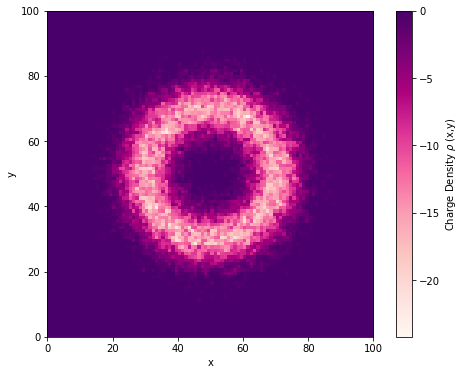

In [67]:
import numpy as np
import matplotlib.pyplot as plt

#Constants
M = 100               # Grid size 
L = 100.0             # Range of x,y coord [0, 100] 
q = -1.0              # Norm. Electron charge

#Data
data = np.loadtxt('particles.dat')
print(f"Loaded {len(data)} particles.")

#Set Up Grid
#Rho is charge density map
rho = np.zeros((M, M))

#Cloud-in-Cel
for p in data:
    x_p, y_p = p[0], p[1]
    
    #Boundaries
    # If particle is exactly at 0 or 100, clip to avoid index errors
    if x_p < 0 or x_p >= L or y_p < 0 or y_p >= L:
        continue

    # Shift coordinates to align with cell centers at i+0.5 
    # Delta is eq to 1 and same for both so we just have to shift coord and not translate distance/ step size
    # Subtract 0.5 because index 0 is at physical position 0.5
    u = x_p - 0.5
    v = y_p - 0.5
    
    #Find the integer index of the nearest bottom-left node
    i = int(np.floor(u))
    j = int(np.floor(v))
    
    #Calculate fractional weights (linear interpolation)
    wx = u - i
    wy = v - j
    
    #Distribute charge to the 4 neighbors
    #Map Y to rows and X to columns -> rho[y, x]
    
    #Weight for (i, j)
    if 0 <= i < M and 0 <= j < M:
        rho[j, i] += q * (1 - wx) * (1 - wy)
        
    #Weight for (i+1, j)
    if 0 <= i+1 < M and 0 <= j < M:
        rho[j, i+1] += q * (wx) * (1 - wy)
        
    #Weight for (i, j+1)
    if 0 <= i < M and 0 <= j+1 < M:
        rho[j+1, i] += q * (1 - wx) * (wy)
        
    #Weight for (i+1, j+1)
    if 0 <= i+1 < M and 0 <= j+1 < M:
        rho[j+1, i+1] += q * (wx) * (wy)

#Plot
plt.figure(figsize=(8, 6))

# Use extent to map the grid indices back to physical coordinates [0, 100]
# origin='lower' to put (0,0) to the bottom left
plt.imshow(rho, extent=[0, L, 0, L], origin='lower', cmap='RdPu')
plt.colorbar(label='Charge Density ' r'$ \rho$' ' (x,y)')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

### b) Solving Poisson's Equation I: Relaxation Method

In [8]:
from numpy import empty,zeros,max
from pylab import imshow,gray,show

# Constants
M = 100         # Grid squares on a side
target = 1e-6   # Target accuracy
a=1.0 #Grid spacing

# Create arrays to hold potential values
phi = zeros([M+1,M+1],float)
phiprime = empty([M+1,M+1],float)

# Main loop
delta = 1.0
iterations = 0

print("Starting relaxation...")

while delta>target:

    # Calculate new values of the potential
    for i in range(M+1):
        for j in range(M+1):
            if i==0 or i==M or j==0 or j==M:
                phiprime[i,j] = 0.0 #Box is grounded everywhere
            else:
                phiprime[i,j] = (phi[i+1,j] + phi[i-1,j] \
                                 + phi[i,j+1] + phi[i,j-1])/4 + rho[i,j]*a**2/4 #with e0=1

    # Calculate maximum difference from old values
    delta = max(abs(phi-phiprime))

    # Swap the two arrays around
    phi,phiprime = phiprime,phi
    
    iterations += 1
    if iterations % 5000 == 0:
        print(f"Iteration {iterations}, delta = {delta}")

print(f"Converged in {iterations} iterations.")

Starting relaxation...
Iteration 5000, delta = 0.16266475385600643
Iteration 10000, delta = 0.01378886631118803
Iteration 15000, delta = 0.0011688897866406478
Iteration 20000, delta = 9.908742913466995e-05
Iteration 25000, delta = 8.399696071137441e-06
Converged in 29311 iterations.


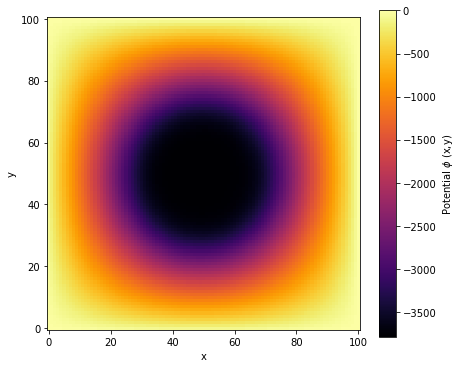

In [68]:
#Make plot
plt.figure(figsize=(7,6))
plt.imshow(phi, origin='lower', cmap='inferno')
plt.colorbar(label='Potential $\phi$' ' (x,y)')
plt.xlabel("x")
plt.ylabel("y")
plt.show()

### c) Solving Poisson's Equation II: Gauss-Seidel Overrelaxation Method

In [52]:
from numpy import empty,zeros,max
from pylab import imshow,gray,show

# Constants
M = 100         # Grid squares on a side
target = 1e-6   # Target accuracy
a=1.0           #Grid spacing
w=0.94202       #Overrelaxation parameter

# Create arrays to hold potential values
phi = zeros([M+1,M+1],float)

# Main loop
delta = 1.0
iterations = 0

print("Starting relaxation...")

while delta>target:
    
    delta=0.0

    # Calculate new values of the potential
    for i in range(M):
        for j in range(M):
                oldval = (phi[i+1,j] + phi[i-1,j] \
                                 + phi[i,j+1] + phi[i,j-1])/4 + rho[i,j]*a**2/4 #with e0=1
                
                
                newval = (1+w)*(phi[i+1,j] + phi[i-1,j] \
                                 + phi[i,j+1] + phi[i,j-1]+ rho[i,j]*a**2)/4 - w*phi[i,j] #with e0=1

                #Calculate difference for convergence check
                diff = abs(newval - phi[i,j])
                
                if diff > delta:
                    delta = diff

                #Update in place
                phi[i,j] = newval
    
    iterations += 1
    if iterations % 100 == 0:
        print(f"Iteration {iterations}, delta = {delta}")

print(f"Converged in {iterations} iterations.")

Starting relaxation...
Iteration 300, delta = 5.432839839158987e-05
Converged in 359 iterations.


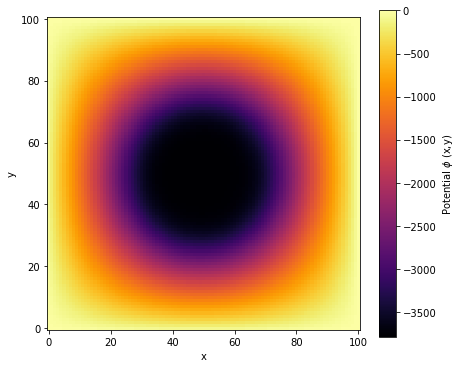

In [69]:
#Make plot
plt.figure(figsize=(7,6))
plt.imshow(phi, origin='lower', cmap='inferno')
plt.colorbar(label='Potential $\phi$' ' (x,y)')
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [103]:
import numpy as np
import matplotlib.pyplot as plt

#Constants
M = 100
target = 1e-6
a = 1.0
epsilon0 = 1.0


#Function to be minimized
def get_iterations(w):
    
    phi = np.zeros([M+1, M+1], float)
    
    delta=1.0
    iterations=0
    
    while delta>target:

        delta=0.0

        # Calculate new values of the potential
        for i in range(1, M):
            for j in range(1, M):
                    oldval = (phi[i+1,j] + phi[i-1,j] \
                                     + phi[i,j+1] + phi[i,j-1])/4 + rho[i,j]*a**2/4 #with e0=1


                    newval = (1+w)*(phi[i+1,j] + phi[i-1,j] \
                                     + phi[i,j+1] + phi[i,j-1]+ rho[i,j]*a**2)/4 - w*phi[i,j] #with e0=1

                    #Calculate difference for convergence check
                    diff = abs(newval - phi[i,j])

                    if diff > delta:
                        delta = diff

                    #Update in place
                    phi[i,j] = newval

        iterations += 1
        
    return iterations

#The Golden Ratio Search
phi_ratio = (1 + np.sqrt(5)) / 2  # Golden Ratio (~1.618)

# Initial Bracket
a_bracket = 0.8
b_bracket = 1.0
precision = 0.001

# Calculate interior points
c_point = b_bracket - (b_bracket - a_bracket) / phi_ratio
d_point = a_bracket + (b_bracket - a_bracket) / phi_ratio

# Evaluate function at interior points
f_c = get_iterations(c_point)
f_d = get_iterations(d_point)

# Lists to store history for plotting
history_w = []          # The current best estimate of w
history_bracket = []    # The width of the bracket (b - a)
step_num = 0

print("Starting Golden Ratio Search...")
print(f"{'Step':<5} {'w_opt':<10} {'Iterations':<12} {'Bracket [a, b]'}")

while abs(b_bracket - a_bracket) > precision:
    
    # Store data for plotting (midpoint of current bracket)
    midpoint = (a_bracket + b_bracket) / 2
    history_w.append(midpoint)
    history_bracket.append([a_bracket, b_bracket])
    
    print(f"{step_num:<5} {midpoint:<10.5f} {min(f_c, f_d):<12} [{a_bracket:.4f}, {b_bracket:.4f}]")
    
    if f_c < f_d:
        # Minimum is in the left part [a, d]
        b_bracket = d_point
        d_point = c_point
        f_d = f_c
        c_point = b_bracket - (b_bracket - a_bracket) / phi_ratio
        f_c = get_iterations(c_point)
    else:
        # Minimum is in the right part [c, b]
        a_bracket = c_point
        c_point = d_point
        f_c = f_d
        d_point = a_bracket + (b_bracket - a_bracket) / phi_ratio
        f_d = get_iterations(d_point)
        
    step_num += 1

optimal_w = (a_bracket + b_bracket) / 2
print(f"\nOptimal w found: {optimal_w:.5f}")
print(f"Iterations at optimal w: {get_iterations(optimal_w)}")

Starting Golden Ratio Search...
Step  w_opt      Iterations   Bracket [a, b]
0     0.90000    622          [0.8000, 1.0000]
1     0.93820    414          [0.8764, 1.0000]
2     0.96180    414          [0.9236, 1.0000]
3     0.94721    350          [0.9236, 0.9708]
4     0.93820    350          [0.9236, 0.9528]
5     0.94377    350          [0.9348, 0.9528]
6     0.94033    350          [0.9348, 0.9459]
7     0.94245    350          [0.9390, 0.9459]
8     0.94114    350          [0.9390, 0.9433]
9     0.94195    350          [0.9406, 0.9433]
10    0.94145    350          [0.9406, 0.9423]
11    0.94176    345          [0.9413, 0.9423]

Optimal w found: 0.94195
Iterations at optimal w: 344


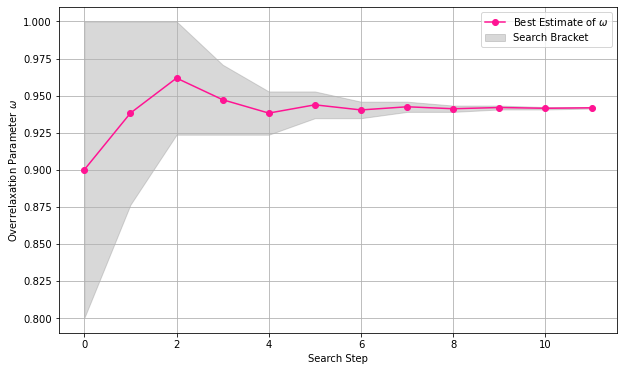

In [104]:
#Plot
steps = range(len(history_w))
brackets = np.array(history_bracket)

plt.figure(figsize=(10, 6))

#Plot the bracket range
plt.fill_between(steps, brackets[:,0], brackets[:,1], color='gray', alpha=0.3, label='Search Bracket')
#Plot the estimated optimal value
plt.plot(steps, history_w, 'o-', color='deeppink',label='Best Estimate of $\omega$')

plt.xlabel('Search Step')
plt.ylabel('Overrelaxation Parameter $\omega$')
plt.legend()
plt.grid(True)
plt.show()